# Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import warnings

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("Train-1.csv")
df_test = pd.read_csv("Test.csv")

In [4]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,54,140,100,15.0,98.0,66,high risk
1,50,140,90,15.0,98.0,90,high risk
2,18,120,80,7.9,102.0,76,mid risk
3,38,135,60,7.9,101.0,86,high risk
4,35,90,70,6.9,98.0,70,low risk


# Data Clearning and Exploration

Interesting observation that Heart Rate for one of the patients is 7. Perhaps that is a misread. Generally, using the describe method gives us a good overview of the overall data (i.e. we can find outliers that are obvious in our data).

In [5]:
df.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000
mean,30.015515,113.337094,76.579690,8.776291,98.705783,74.579690
std,13.496119,18.472167,13.861438,3.323225,1.398398,8.002361
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,95.000000,65.000000,6.900000,98.000000,70.000000
50%,27.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


Simply remove the outlier, so that the data won't be affected. One simple way is to replace the outlier by the mean of the values in that specific column.

In [6]:
df.loc[df["HeartRate"] == 7, "HeartRate"] = df["HeartRate"].mean()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          709 non-null    int64  
 1   SystolicBP   709 non-null    int64  
 2   DiastolicBP  709 non-null    int64  
 3   BS           709 non-null    float64
 4   BodyTemp     709 non-null    float64
 5   HeartRate    709 non-null    float64
 6   RiskLevel    709 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 38.9+ KB


In [8]:
df.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000
mean,30.015515,113.337094,76.579690,8.776291,98.705783,74.675007
std,13.496119,18.472167,13.861438,3.323225,1.398398,7.588023
min,10.000000,70.000000,49.000000,6.000000,98.000000,60.000000
25%,19.000000,95.000000,65.000000,6.900000,98.000000,70.000000
50%,27.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


Check if there are any null values in the data frame.

In [9]:
df.isnull().values.any()

False

In [10]:
df_test.isnull().values.any()

False

Check if there are any duplicates, and remove them. I have decided to not remove them, because the duplicates might be actual readings of the data.

In [24]:
df.duplicated().any()

True

In [25]:
df_test.duplicated().any()

True

The Heart Rate will be more spread out (higher standard deviation) for high risk women than mid/low risk. This shows a more centered Heart Rate for mid/low risk.

The BS (blood sugar) seems to be higher for mid/low risk women, than high risk. However, we can analyze the data and note that the high levels of blood sugar for low risk women is caused by outliers (i.e. there are about 150 values above 12 BS for low risk women, but the rest of 864 is below that value). My guess is that there is some cofounding variable that influences the blood sugar levels for all types of risks that has not been included in the data set.

There is obvious spike in the BS for both mid/low risk, which indicates a high mode and small standard deviation. For the high risk, we can see that the values are more spread out, so there is a higher standard deviation.

The body temperature of low risk women will be higher than mid/high risk. The high risk values are smaller. All 3 types of risk are right skewed, with the mean of body temperature at roughly 98 Fahrenheit degrees.

Age is right skewed for mid/low risk women. There is a large number of women for mid/low risk with the distribution's mean of 20 years old. The high risk is more distributed.

DiastolicBP is left skewerd for high risk women.

SystolicBP will have outliers for low/mid risk women.

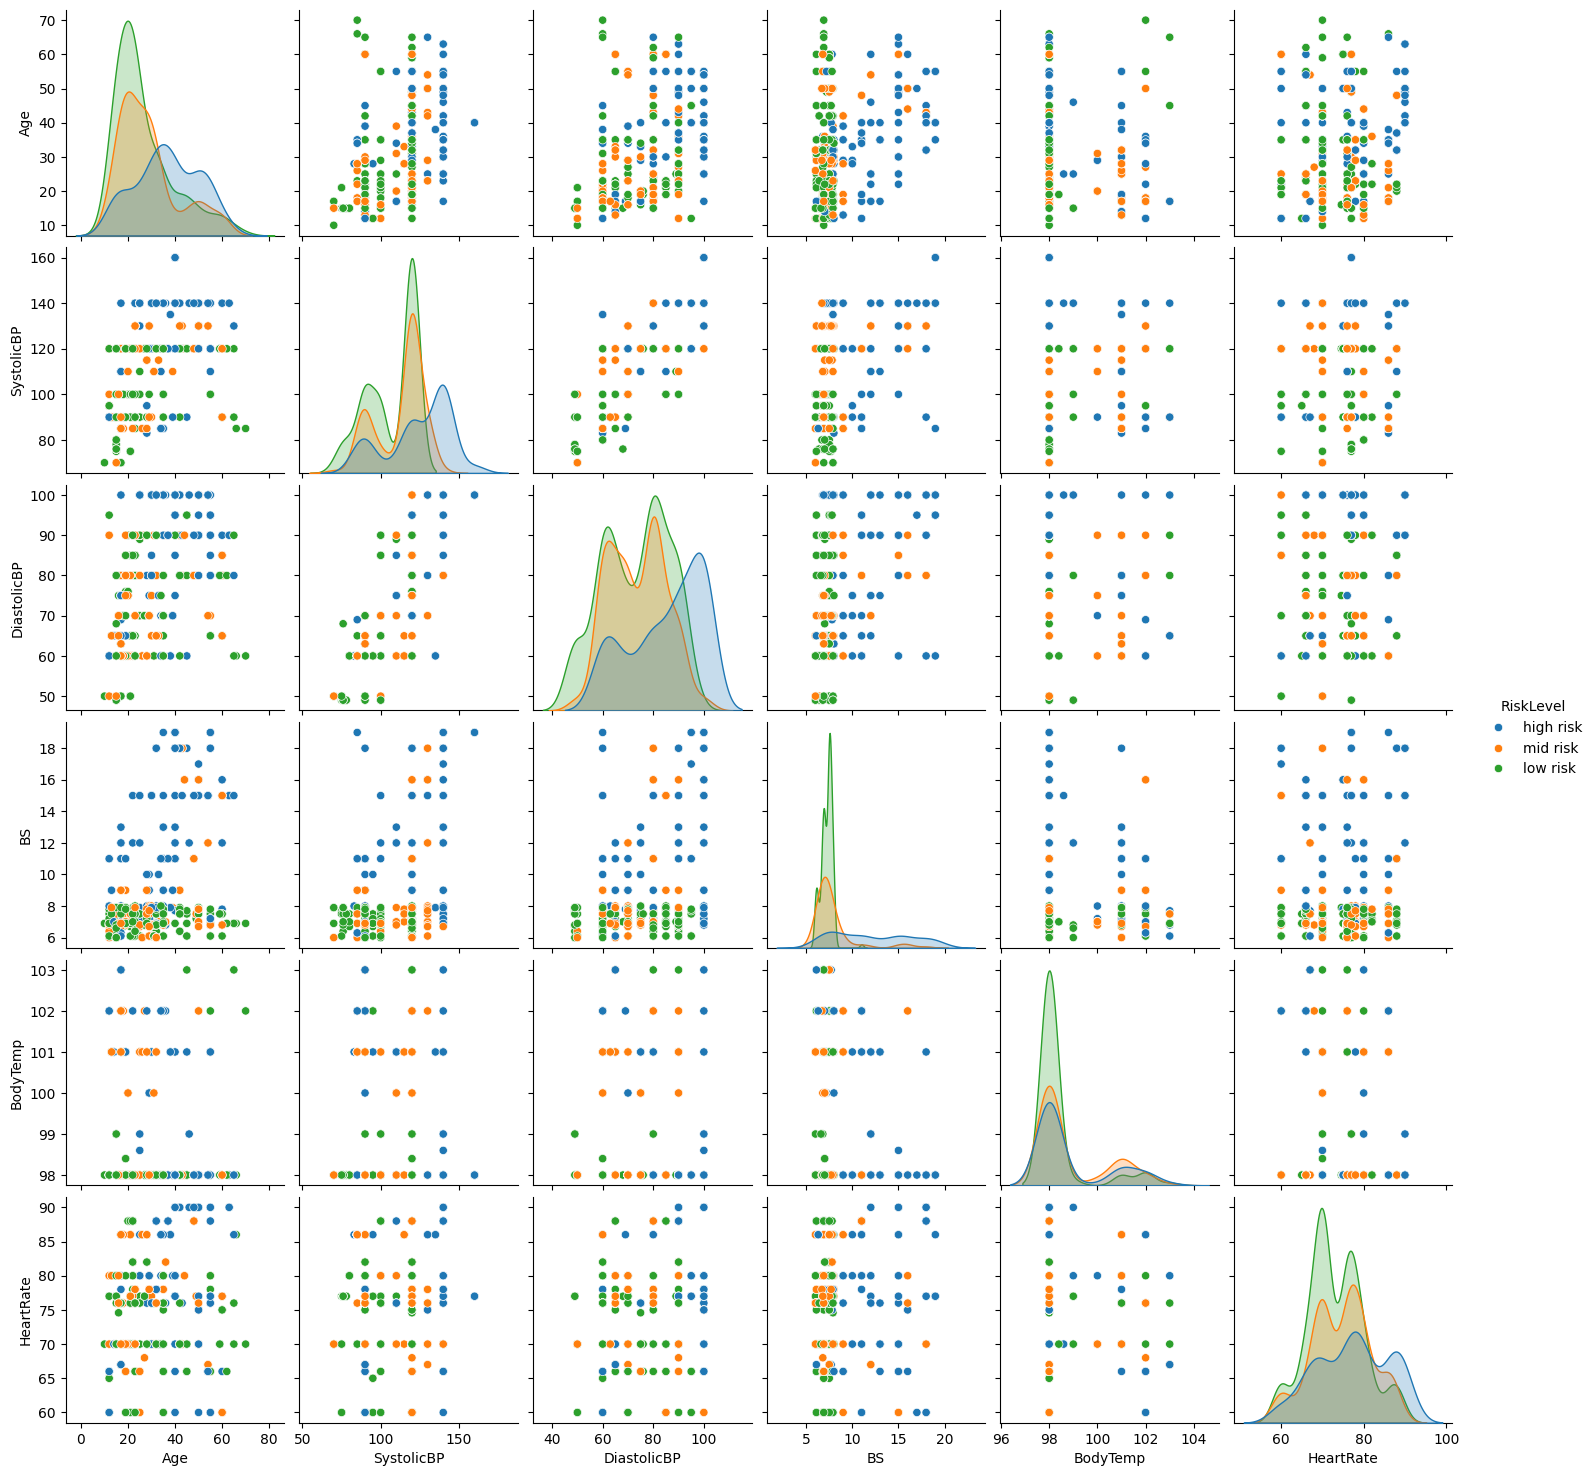

In [13]:
sns.pairplot(df, hue="RiskLevel")

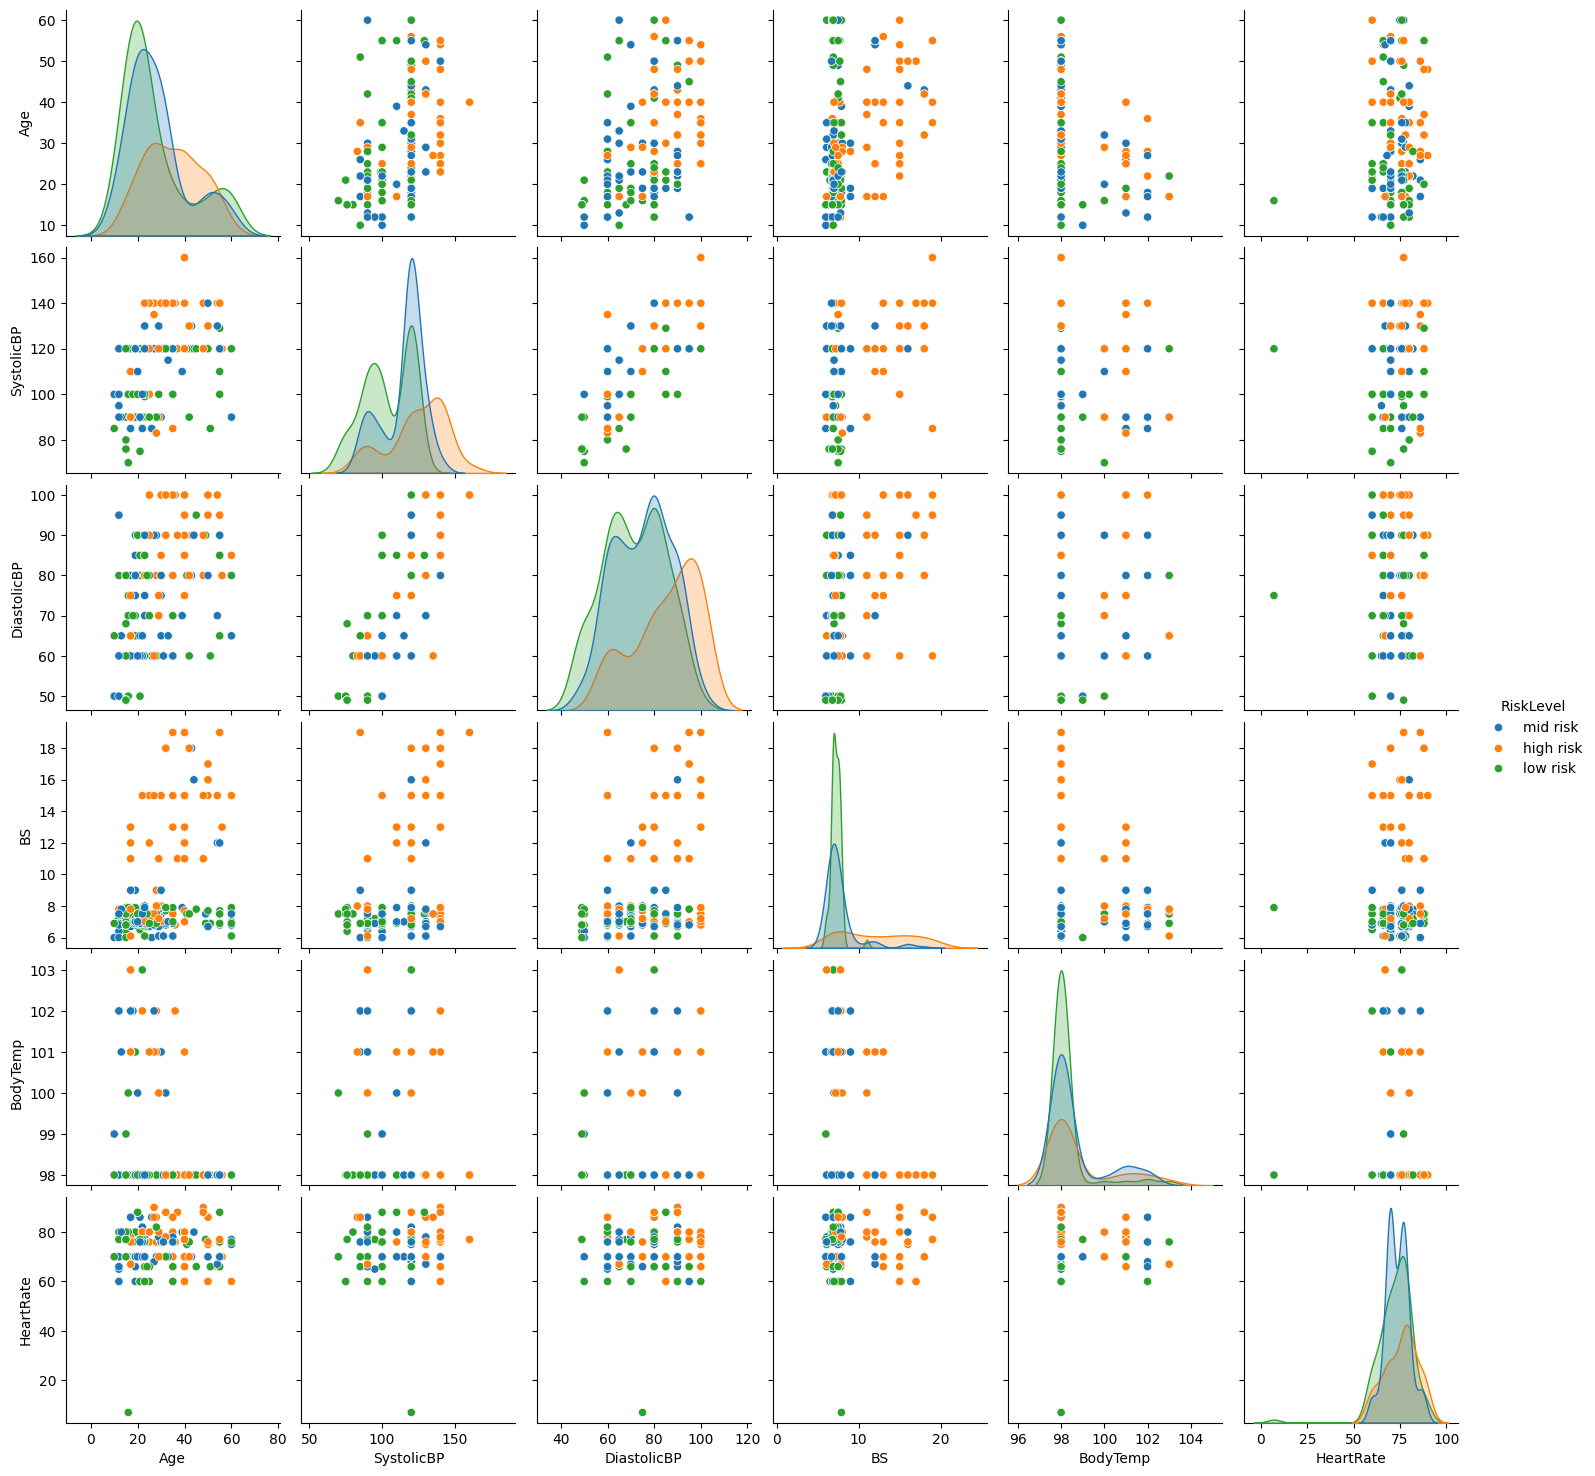

In [14]:
sns.pairplot(df_test, hue="RiskLevel")

The data is unbalanced, as the values for each class are different.

<Axes: xlabel='RiskLevel', ylabel='count'>

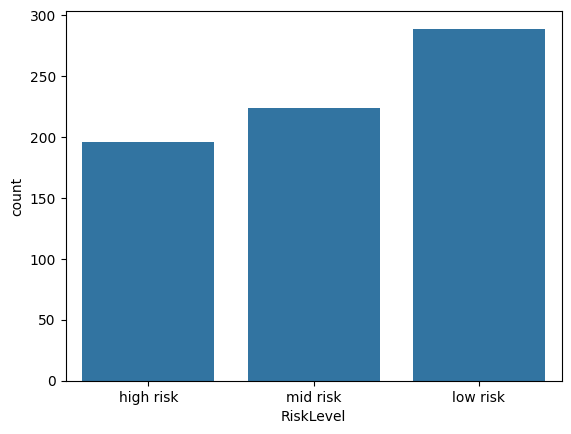

In [26]:
sns.countplot(df, x=df["RiskLevel"])

We can note that the classes are not balanced (i.e. low risk has almost 50% of the samples).

In [16]:
len(df[df["RiskLevel"] == "low risk"]), len(df[df["RiskLevel"] == "mid risk"]), len(df[df["RiskLevel"] == "high risk"]), len(df)

(289, 224, 196, 709)

The following represent the percentages of the data distribution:

In [17]:
len(df[df["RiskLevel"] == "low risk"]) * 100 / len(df), len(df[df["RiskLevel"] == "mid risk"]) * 100 / len(df), len(df[df["RiskLevel"] == "high risk"]) * 100 / len(df)

(40.76163610719323, 31.59379407616361, 27.64456981664316)

Here we replace the categorical data with numerical values, so that we can use it to represent y_test and y_train. Another option would be to use one hot encoding, but in this case I opted for simply setting values from 0 to 2, as the values are ordinally ordered.

In [27]:
df = df.replace({"high risk":2, "mid risk":1, "low risk":0})
df_test = df_test.replace({"high risk":2, "mid risk":1, "low risk":0})

The correlation between different variables and the risk level can be found using the correlation method. It can be seen clearly that the predictors with the highest influence on the risk level are Blood Sugar (BS), SystolicBP and DiastolicBP. It is crucial to note what features influence the predictions, as we can draw conclusions based on various influencers. For instance, if we know that Blood Sugar is a high correlator, then we might think of ways in which we can reduce Blood Sugar, or perhaps we might try to find a cofounding variable that influences both Blood Sugar and the risk type.

In [28]:
df.corr()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
Age,1.000000,0.445465,0.424106,0.492717,-0.246412,0.059023,0.291920
SystolicBP,0.445465,1.000000,0.799290,0.441792,-0.314943,-0.011551,0.377111
DiastolicBP,0.424106,0.799290,1.000000,0.437296,-0.295290,-0.063356,0.337154
BS,0.492717,0.441792,0.437296,1.000000,-0.109712,0.168158,0.577716
BodyTemp,-0.246412,-0.314943,-0.295290,-0.109712,1.000000,0.124407,0.157511
HeartRate,0.059023,-0.011551,-0.063356,0.168158,0.124407,1.000000,0.215980
RiskLevel,0.291920,0.377111,0.337154,0.577716,0.157511,0.215980,1.000000


The column we want to predict is dropped, and the predictors are all placed inside the X variable.

In [29]:
X_train = df.drop(["RiskLevel"], axis=1)
y_train = df["RiskLevel"]

In [30]:
X_test = df_test.drop(["RiskLevel"], axis=1)
y_test = df_test["RiskLevel"]

Here we compare the X and y values using box plots. One of the most strinking issues within the test data is that the outliers for BodyTemp prevent it from being normally distruted. We also cannot apply log/sqrt on this type of data to remove its right skew, as most of the values are at exactly 98 (i.e. therefore a lot of the values will be at that point).

There are some outliers for the BS component, that makes the modes for low/mid risk to be extremely high.  

<Axes: xlabel='RiskLevel', ylabel='HeartRate'>

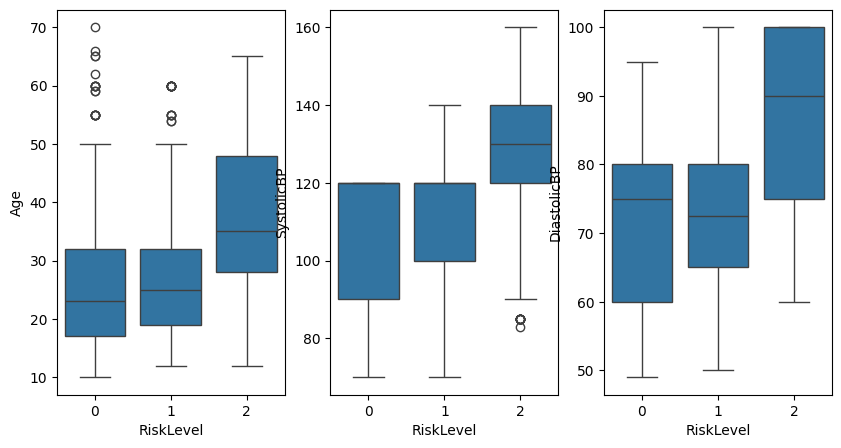

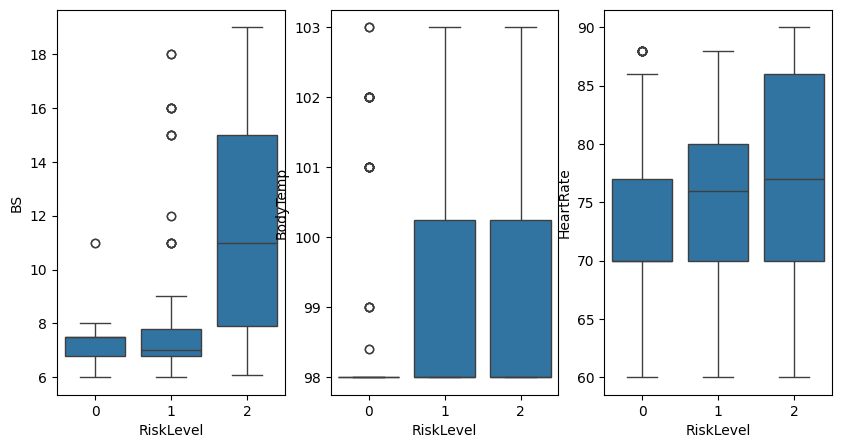

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
sns.boxplot(x=y_train, y="Age", data=X_train, ax=ax[0])
sns.boxplot(x=y_train, y="SystolicBP", data=X_train, ax=ax[1])
sns.boxplot(x=y_train, y="DiastolicBP", data=X_train, ax=ax[2])

fig1, ax1 = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
sns.boxplot(x=y_train, y="BS", data=X_train, ax=ax1[0])
sns.boxplot(x=y_train, y="BodyTemp", data=X_train, ax=ax1[1])
sns.boxplot(x=y_train, y="HeartRate", data=X_train, ax=ax1[2])

The independent variables are standardised using z-scores, so that all the values can be measured in terms of standard deviations.

In [32]:
standard_scaler = StandardScaler()
standard_scaler.fit(X_train)
X_scaled_train = standard_scaler.transform(X_train)
X_scaled_test = standard_scaler.transform(X_test)

# Random Forest

In [21]:
289/709, 224/709, 196/709

(0.4076163610719323, 0.3159379407616361, 0.2764456981664316)

In [32]:
class_weight = {0: 0.4076163610719323, 1: 0.3159379407616361, 2: 0.2764456981664316} # data is not distrubted evenly, so it has to be split
forest = RandomForestClassifier(random_state=0)

In [33]:
param_grid_forest = {
    "n_estimators": [100, 200, 500],
    "criterion": ["gini", "entropy"], # criterior, either gini or entropy
    "n_jobs": [-1], # parallizes the process, making it way faster for a slight decrease in performance
    "class_weight": [class_weight],
    "max_depth": [30, 40, 50],
}

grid_forest = GridSearchCV(RandomForestClassifier(), param_grid_forest, cv=10)
grid_forest.fit(X_train, y_train)
grid_forest.best_params_, grid_forest.best_score_

({'class_weight': {0: 0.4076163610719323,
   1: 0.3159379407616361,
   2: 0.2764456981664316},
  'criterion': 'gini',
  'max_depth': 40,
  'n_estimators': 200,
  'n_jobs': -1},
 0.870281690140845)

In [34]:
model_forest = grid_forest.best_estimator_
prediction_forest = model_forest.predict(X_test)

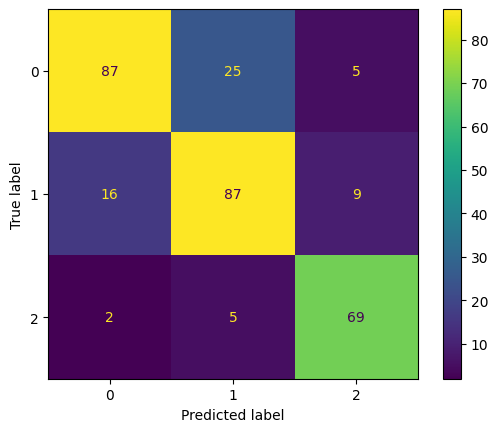

In [35]:
ConfusionMatrixDisplay(confusion_matrix(y_test, prediction_forest)).plot()

In [36]:
print(classification_report(y_test, prediction_forest))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       117
           1       0.74      0.78      0.76       112
           2       0.83      0.91      0.87        76

    accuracy                           0.80       305
   macro avg       0.80      0.81      0.80       305
weighted avg       0.80      0.80      0.80       305



Accuracy of the Random Forest on the test data set.

In [37]:
accuracy_score(y_test, prediction_forest)

0.7967213114754098

Accuracy of the Random Forest on the train data set.

In [38]:
model_forest.score(X_train, y_train)

0.9464033850493653

# Support Vector Machines

In [39]:
svc = SVC(random_state=0)

In [40]:
param_grid_svc = {
    "kernel": ["linear", "rbf"], # type of hyperplaned used
    "gamma": [20, 30, 50], # higher gamma, the more you try to fit data for non-linear hyperplanes
    "C" : [30, 40, 50], # trade off between smooth boundary and classifying correct values (penalty parameter of the error)
    "class_weight": [class_weight],
}
grid_svc = GridSearchCV(SVC(), param_grid_svc, cv=10)
grid_svc.fit(X_train, y_train)
grid_svc.best_params_, grid_svc.best_score_

({'C': 30,
  'class_weight': {0: 0.4076163610719323,
   1: 0.3159379407616361,
   2: 0.2764456981664316},
  'gamma': 20,
  'kernel': 'rbf'},
 0.8251710261569416)

In [41]:
grid_svc.best_score_

0.8251710261569416

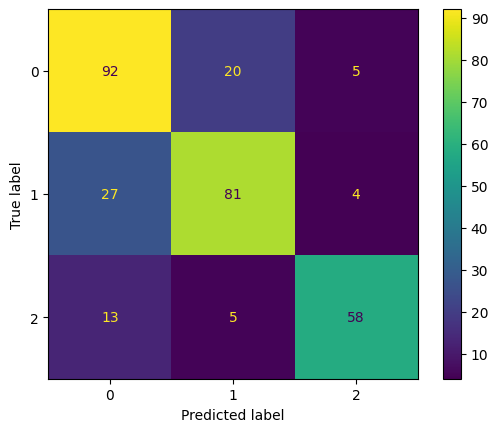

In [42]:
model_svc = grid_svc.best_estimator_
prediction_svc = model_svc.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, prediction_svc)).plot()

In [43]:
print(classification_report(y_test, prediction_svc))

              precision    recall  f1-score   support

           0       0.70      0.79      0.74       117
           1       0.76      0.72      0.74       112
           2       0.87      0.76      0.81        76

    accuracy                           0.76       305
   macro avg       0.78      0.76      0.76       305
weighted avg       0.76      0.76      0.76       305



Accuracy of the Support Vector Machine on the test data set.

In [44]:
model_svc.score(X_test, y_test)

0.7573770491803279

Accuracy of the Support Vector Machine on the train data set.

In [45]:
model_svc.score(X_train, y_train)

0.9464033850493653